# MORE EFFICIENT PORTFOLIO ALLOCATION WITH QUASI-MONTE CARLO METHODS USING QMCPY
Larysa Matiukha and Sou-Cheng T. Choi

Illinois Institute of Technology

Modification date: 12/13/2025

In [1]:
import qmcpy as qp
import pandas as pd
import numpy as np

try:
    import yfinance as yf
except ImportError:
    !pip install -q yfinance
    import yfinance as yf

import seaborn as sn
import matplotlib.pyplot as plt
import time

from scipy.optimize import minimize
import timeit


In [2]:
# make folders `data` and `images`
import os
data_dir = 'data' + os.sep
images_dir = 'images' + os.sep
if not os.path.exists('data'):
    os.makedirs(data_dir)
if not os.path.exists('images'):
    os.makedirs(images_dir)

*Portfolio allocation* is a strategic process that aims to balance risk and return by distributing funds among diverse assets with varying risks and returns [5]. The goal is to create a diversified portfolio that can mitigate risk and  enhance returns over time, while  reducing the impact of market changes on individual assets. In this study for portfolio allocation, utilizing the open-source QMCPy library[2,3], we apply quasi-Monte Carlo methods in the distribution of funds among individual stocks in a portfolio.

In [3]:
start_date = '2014-01-01'
#today = date.today()
end_date = '2025-12-13'

In [4]:
def download_data(tickers, description):
    col_names = ['Ticker', 'Company', 'Date', 'Adj Close Price', 'Volume']
    rows = []
    for i, ticker in enumerate(tickers):
        company = description[i]
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            print(f"Warning: no data for {ticker}")
            continue
        data = data.reset_index()
        
        # Handle column names robustly (could be MultiIndex or different names)
        cols = list(data.columns)
        
        # Find date column
        date_col = next((c for c in cols if 'Date' in str(c) or 'date' in str(c)), cols[0])
        
        # Find adj close column
        adj_col_candidates = [c for c in cols if 'Adj' in str(c)]
        if not adj_col_candidates:
            adj_col_candidates = [c for c in cols if 'Close' in str(c)]
        
        # Find volume column
        vol_col_candidates = [c for c in cols if 'Volume' in str(c) or 'Vol' in str(c)]
        
        if not adj_col_candidates or not vol_col_candidates:
            raise KeyError(f"Adj Close or Volume column not found for {ticker}. Columns: {cols}")
        
        adj_col_sel = adj_col_candidates[0]
        vol_col_sel = vol_col_candidates[0]
        
        # Select and rename columns
        data = data[[date_col, adj_col_sel, vol_col_sel]].copy()
        data.insert(0, 'Company', company)
        data.insert(0, 'Ticker', ticker)
        data.columns = col_names
        rows.append(data)
    
    df = pd.concat(rows, ignore_index=True)
    return df


In [5]:
def get_log_ret(df):
    stocks = df.pivot(index='Date', columns='Ticker', values='Adj Close Price')
    log_ret = np.log(stocks/stocks.shift(1))

    return log_ret

# Generating Portfolio Weights

We implement functions to generate portfolio weights using different sampling methods:
- **Lattice** (QMC) — Low-discrepancy sequence with good space-filling properties
- **Sobol** (QMC) — Another low-discrepancy sequence, popular in finance
- **Halton** (QMC) — Low-discrepancy sequence based on prime bases
- **IID** (MC) — Traditional Monte Carlo with pseudo-random uniform samples

The weights are normalized to sum to 1 for each portfolio (simplex constraint).

In [6]:
def gen_weights(sampler_type, n, num_ports, seed=42):
    """
    Generate portfolio weights using specified sampling method.
    
    Parameters:
        sampler_type: str - 'lattice', 'sobol', 'halton', or 'iid'
        n: int - number of assets (dimension)
        num_ports: int - number of portfolios to generate
        seed: int - random seed for reproducibility
    
    Returns:
        weights: ndarray of shape (num_ports, n) with rows summing to 1
    """
    if sampler_type == 'lattice':
        sampler = qp.Lattice(dimension=n, seed=seed)
        weights = sampler.gen_samples(num_ports)
    elif sampler_type == 'sobol':
        sampler = qp.Sobol(dimension=n, seed=seed)
        weights = sampler.gen_samples(num_ports)
    elif sampler_type == 'halton':
        sampler = qp.Halton(dimension=n, seed=seed)
        weights = sampler.gen_samples(num_ports)
    elif sampler_type == 'iid':
        np.random.seed(seed)
        weights = np.random.random((num_ports, n))
    else:
        raise ValueError(f"Unknown sampler type: {sampler_type}. Use 'lattice', 'sobol', 'halton', or 'iid'.")
    
    # Normalize weights to sum to 1 (simplex projection)
    weights /= weights.sum(axis=1, keepdims=True)
    return weights

# Legacy functions for backward compatibility
def gen_weights_lattice(n, num_ports):
    return gen_weights('lattice', n, num_ports)

def gen_weights_sobol(n, num_ports):
    return gen_weights('sobol', n, num_ports)

def gen_weights_halton(n, num_ports):
    return gen_weights('halton', n, num_ports)

def gen_weights_iid(n, num_ports):
    return gen_weights('iid', n, num_ports)

## Computing Sharpe Ratio
Sharpe Ratio is given by: $\frac{R}{V}$, where $R = \sum_{i=1}^{d} R_iw_i$ stands for the excess expected return of a portfolio and $V = \sqrt{\sum_{i=1}^{d} \sum_{j=1}^{d} \sigma_{ij} w_i w_j}$ represents  its expected volatility with $d$ number of assets in a portfolio, weights $w_i$'s, and covariance of assets $i$ and $j$ $\sigma_{ij}$

In [7]:
def sharpe(weights,log_ret):
    np.random.seed(42)
    # Expected return
    ret_arr = np.sum((log_ret.mean().values * weights * 252), axis=1)

    # Expected volatility
    vol_arr = np.sqrt((weights @ (log_ret.cov().values * 252)) @ weights.T).diagonal()

    # Sharpe Ratio
    sharpe_arr = ret_arr/vol_arr

    # Rounding values
    sharpe_arr = np.round(sharpe_arr, decimals=3)
    ret_arr = np.round(ret_arr, decimals=3)
    vol_arr = np.round(vol_arr, decimals=3)
    all_weights = np.round(weights, decimals=3)

    # max
    max_sharpe_ratio = sharpe_arr.max()
    location_in_array = sharpe_arr.argmax()
    max_sr_ret = ret_arr[location_in_array]
    max_sr_vol = vol_arr[location_in_array]
    max_sharpe_ratio = np.round(max_sr_ret/max_sr_vol,decimals=3)

    # mid
    medium_risk_tolerance = np.quantile(vol_arr, 2/3, axis=0)
    medium_risk_idx = np.where(vol_arr<medium_risk_tolerance)
    medium_risk_max_sharpe_ratio = sharpe_arr[medium_risk_idx].max()
    location_in_array = sharpe_arr[medium_risk_idx].argmax()
    medium_risk_sr_ret = ret_arr[medium_risk_idx][location_in_array]
    medium_risk_sr_vol = vol_arr[medium_risk_idx][location_in_array]
    medium_risk_max_sharpe_ratio = np.round(medium_risk_sr_ret/medium_risk_sr_vol,decimals=3)

    # low
    low_risk_tolerance = np.quantile(vol_arr, 1/3, axis=0)
    low_risk_idx = np.where(vol_arr<low_risk_tolerance)
    low_risk_max_sharpe_ratio = sharpe_arr[low_risk_idx].max()
    location_in_array = sharpe_arr[low_risk_idx].argmax()
    low_risk_sr_ret = ret_arr[low_risk_idx][location_in_array]
    low_risk_sr_vol = vol_arr[low_risk_idx][location_in_array]
    low_risk_max_sharpe_ratio = np.round(low_risk_sr_ret/low_risk_sr_vol,decimals =3)

    return {"number of tickers":len(weights[0]),"number of portfolios":len(weights),"low": all_weights[low_risk_idx][location_in_array].tolist(), "medium": all_weights[medium_risk_idx][location_in_array].tolist(), "high": all_weights[location_in_array].tolist(),
            "low risk Sharpe":low_risk_max_sharpe_ratio,"medium risk Sharpe":medium_risk_max_sharpe_ratio,"high risk Sharpe":max_sharpe_ratio}


# Testing Sharpe ratios
We now test the two approaches by computing Sharpe ratios at different risk levels employing the weights obtained from each method.

As we can see from the tables below, the values of Sharpe ratio do not significantly change based on the number of portfolios. We might want to look furher into this: will results change more significantly if we triple the number of portfolios for the tickers we worked with, or what happens if we use much greater number of tickers to begin with.


## Testing Sharpe ratios with lattice weights for four tickers
We start with obtaining the data for four tickers and generate three different arrays of weights for the tickers using lattice points. We then compute the Sharpe ratios for three different levels of risk strategies using the log returns and the generated weights. 

In [8]:
tickers = ["AAPL", "AMZN", "CSCO", "IBM"]
description = ["Apple", "Amazon", "CISCO", "IBM"]

# robust download to avoid "['Adj Close'] not in index" errors
rows = []
for t, comp in zip(tickers, description):
    data = yf.download(t, start=start_date, end=end_date)
    if data.empty:
        print(f"Warning: no data for {t}")
        continue
    data = data.reset_index()
    # find appropriate columns (handles possible MultiIndex or different names)
    adj_col_candidates = [c for c in data.columns if 'Adj' in str(c)]
    vol_col_candidates = [c for c in data.columns if 'Volume' in str(c) or 'Vol' in str(c)]
    # fall back to 'Close' column when 'Adj' not available (handles MultiIndex)
    if not adj_col_candidates:
        adj_col_candidates = [c for c in data.columns if 'Close' in str(c) or 'Adj' in str(c)]
    if not adj_col_candidates or not vol_col_candidates:
        raise KeyError(f"Adj Close or Volume column not found for {t}. Columns: {list(data.columns)}")
    adj_col = adj_col_candidates[0]
    vol_col = vol_col_candidates[0]
    # select columns robustly even if columns are a MultiIndex
    cols = list(data.columns)
    date_col = next((c for c in cols if 'Date' in str(c) or 'date' in str(c)), cols[0])
    adj_col_sel = next((c for c in cols if (('Adj' in str(c) or 'Adj Close' in str(c) or 'Adjusted' in str(c) or 'Close' in str(c)) and c != date_col)), None)
    vol_col_sel = next((c for c in cols if 'Volume' in str(c) or 'Vol' in str(c)), None)
    if adj_col_sel is None or vol_col_sel is None:
        raise KeyError(f"Adj Close or Volume column not found for {t}. Columns: {cols}")
    data = data[[date_col, adj_col_sel, vol_col_sel]].copy()
    data.insert(0, 'Company', comp)
    data.insert(0, 'Ticker', t)
    data.columns = ['Ticker', 'Company', 'Date', 'Adj Close Price', 'Volume']
    rows.append(data)
df = pd.concat(rows, ignore_index=True)

# log return for the 4 stocks
lr = get_log_ret(df)

w1_qmc = gen_weights_lattice(4,2**13)
sr1_qmc = sharpe(w1_qmc,lr)

w2_qmc = gen_weights_lattice(4,2**14)
sr2_qmc = sharpe(w2_qmc,lr)

w3_qmc = gen_weights_lattice(4,2**15)
sr3_qmc = sharpe(w3_qmc,lr)

data_qmc = {
    'number of tickers': [len(w1_qmc[0]), len(w1_qmc[0]), len(w1_qmc[0])],
    'number of portfolios': [len(w1_qmc),len(w2_qmc),len(w3_qmc)],
    'low risk Sharpe': [sr1_qmc['low risk Sharpe'],sr2_qmc['low risk Sharpe'],sr3_qmc['low risk Sharpe']],
    'medium risk Sharpe': [sr1_qmc['medium risk Sharpe'],sr2_qmc['medium risk Sharpe'],sr3_qmc['medium risk Sharpe']],
    'high risk Sharpe': [sr1_qmc['high risk Sharpe'],sr2_qmc['high risk Sharpe'],sr3_qmc['high risk Sharpe']]

}
df_qmc = pd.DataFrame.from_dict(data_qmc, orient='columns')
df_qmc = df_qmc.pivot(index='number of portfolios', columns='number of tickers')
df_qmc

/var/folders/l3/wz4prc5d4kv118mgp30jj3_m0000gn/T/ipykernel_23550/532831652.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(t, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/l3/wz4prc5d4kv118mgp30jj3_m0000gn/T/ipykernel_23550/532831652.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(t, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/l3/wz4prc5d4kv118mgp30jj3_m0000gn/T/ipykernel_23550/532831652.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(t, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/l3/wz4prc5d4kv118mgp30jj3_m0000gn/T/ipykernel_23550/532831652.py:7: FutureWarning: YF.download() has changed argument auto_adjust defau

,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,4,4,4
number of portfolios,,,
8192,0.803,0.839,0.856
16384,0.808,0.839,0.856
32768,0.808,0.839,0.856


In [9]:
data

,Ticker,Company,Date,Adj Close Price,Volume
0,IBM,IBM,2014-01-02,109.670715,4755639
1,IBM,IBM,2014-01-03,110.326874,4250107
2,IBM,IBM,2014-01-06,109.948593,4254919
3,IBM,IBM,2014-01-07,112.141602,6205186
4,IBM,IBM,2014-01-08,111.112999,4815470
...,...,...,...,...,...
3001,IBM,IBM,2025-12-08,309.179993,3630200
3002,IBM,IBM,2025-12-09,310.480011,2935300
3003,IBM,IBM,2025-12-10,312.670013,3411500
3004,IBM,IBM,2025-12-11,310.739990,2755700


## Testing Sharpe ratios with iid weights for four tickers
We download the data for the same tickers and repeat the process using iid points to generate the weights.

In [10]:
np.random.seed(42)

# generate weights with iid points
w1_mc = gen_weights_iid(4,2**13)
sr1_mc = sharpe(w1_mc,lr)

w2_mc = gen_weights_iid(4,2**14)
sr2_mc = sharpe(w2_mc,lr)

w3_mc = gen_weights_iid(4,2**15)
sr3_mc = sharpe(w3_mc,lr)

data_mc = {
    'number of tickers': [len(w1_mc[0]), len(w1_mc[0]), len(w1_mc[0])],
    'number of portfolios': [len(w1_mc),len(w2_mc),len(w3_mc)],
    'low risk Sharpe': [sr1_mc['low risk Sharpe'],sr2_mc['low risk Sharpe'],sr3_mc['low risk Sharpe']],
    'medium risk Sharpe': [sr1_mc['medium risk Sharpe'],sr2_mc['medium risk Sharpe'],sr3_mc['medium risk Sharpe']],
    'high risk Sharpe': [sr1_mc['high risk Sharpe'],sr2_mc['high risk Sharpe'],sr3_mc['high risk Sharpe']]

}
df_mc = pd.DataFrame.from_dict(data_mc, orient='columns')
df_mc = df_mc.pivot(index='number of portfolios', columns='number of tickers')
df_mc

,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,4,4,4
number of portfolios,,,
8192,0.808,0.839,0.859
16384,0.808,0.839,0.859
32768,0.808,0.839,0.859


## Testing Sharpe ratios with lattice weights for ten tickers

Now, we dowload the data for 10 tickers and generate new weights using lattice points and compute the Sharpe ratios. We use the same number of portfolios (sampling points) as in the case with four tickers.

In [11]:
from pathlib import Path

fname = f"{data_dir}df1_{start_date}_to_{end_date}.csv"
p = Path(fname)

if p.exists():
    df1 = pd.read_csv(p, parse_dates=['Date'])
else:
    rows = []
    tickers1 = ["AAPL", "AMZN", "CSCO", "IBM", "TSLA", "META", "ABNB", "UPS", "NFLX", "MRNA"]
    description1 = ["Apple", "Amazon", "CISCO", "IBM", "Tesla", "Meta", "Airbnb", "UPS", "Netflix", "Moderna"]

    for t, comp in zip(tickers1, description1):
        data = yf.download(t, start=start_date, end=end_date)
        if data.empty:
            print(f"Warning: no data for {t}")
            continue
        data = data.reset_index()
        cols = list(data.columns)
        adj_col_candidates = [c for c in cols if 'Adj' in str(c)]
        if not adj_col_candidates:
            adj_col_candidates = [c for c in cols if 'Close' in str(c)]
        vol_col_candidates = [c for c in cols if 'Volume' in str(c) or 'Vol' in str(c)]
        if not adj_col_candidates or not vol_col_candidates:
            raise KeyError(f"Adj Close or Volume column not found for {t}. Columns: {cols}")
        date_col = next((c for c in cols if 'Date' in str(c) or 'date' in str(c)), cols[0])
        adj_col_sel = adj_col_candidates[0]
        vol_col_sel = vol_col_candidates[0]
        data = data[[date_col, adj_col_sel, vol_col_sel]].copy()
        data.insert(0, 'Company', comp)
        data.insert(0, 'Ticker', t)
        data.columns = ['Ticker', 'Company', 'Date', 'Adj Close Price', 'Volume']
        rows.append(data)
    df1 = pd.concat(rows, ignore_index=True)
    df1.to_csv(p, index=False)

# compute log returns and QMC results (use actual number of tickers downloaded)
lr1 = get_log_ret(df1)
n_tickers = lr1.shape[1]

w1_qmc10 = gen_weights_lattice(n_tickers, 2**13)
sr1_qmc10 = sharpe(w1_qmc10, lr1)

w2_qmc10 = gen_weights_lattice(n_tickers, 2**14)
sr2_qmc10 = sharpe(w2_qmc10, lr1)

w3_qmc10 = gen_weights_lattice(n_tickers, 2**15)
sr3_qmc10 = sharpe(w3_qmc10, lr1)

data_qmc10 = {
    'number of tickers': [n_tickers, n_tickers, n_tickers],
    'number of portfolios': [len(w1_qmc10), len(w2_qmc10), len(w3_qmc10)],
    'low risk Sharpe': [sr1_qmc10['low risk Sharpe'], sr2_qmc10['low risk Sharpe'], sr3_qmc10['low risk Sharpe']],
    'medium risk Sharpe': [sr1_qmc10['medium risk Sharpe'], sr2_qmc10['medium risk Sharpe'], sr3_qmc10['medium risk Sharpe']],
    'high risk Sharpe': [sr1_qmc10['high risk Sharpe'], sr2_qmc10['high risk Sharpe'], sr3_qmc10['high risk Sharpe']]
}
df_qmc10 = pd.DataFrame.from_dict(data_qmc10, orient='columns')
df_qmc10 = df_qmc10.pivot(index='number of portfolios', columns='number of tickers')
df_qmc10

,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,10,10,10
number of portfolios,,,
8192,0.820,0.821,0.821
16384,0.829,0.829,0.829
32768,0.829,0.839,0.839


## Testing Sharpe ratios with iid weights for ten tickers
We repeat the above procedure using iid points 

In [12]:
np.random.seed(42)

w1_mc10 = gen_weights_iid(10,2**13)
sr1_mc10 = sharpe(w1_mc10,lr1)

w2_mc10 = gen_weights_iid(10,2**14)
sr2_mc10= sharpe(w2_mc10,lr1)

w3_mc10 = gen_weights_iid(10,2**15)
sr3_mc10 = sharpe(w3_mc10,lr1)

data_mc10 = {
    'number of tickers': [len(w1_mc10[0]), len(w1_mc10[0]), len(w1_mc10[0])],
    'number of portfolios': [len(w1_mc10),len(w2_mc10),len(w3_mc10)],
    'low risk Sharpe': [sr1_mc10['low risk Sharpe'],sr2_mc10['low risk Sharpe'],sr3_mc10['low risk Sharpe']],
    'medium risk Sharpe': [sr1_mc10['medium risk Sharpe'],sr2_mc10['medium risk Sharpe'],sr3_mc10['medium risk Sharpe']],
    'high risk Sharpe': [sr1_mc10['high risk Sharpe'],sr2_mc10['high risk Sharpe'],sr3_mc10['high risk Sharpe']]

}
df_mc10 = pd.DataFrame.from_dict(data_mc10, orient='columns')
df_mc10 = df_mc10.pivot(index='number of portfolios', columns='number of tickers')
df_mc10

,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,10,10,10
number of portfolios,,,
8192,0.831,0.835,0.835
16384,0.831,0.835,0.835
32768,0.831,0.835,0.835


## Testing Sharpe ratios with lattice weights for twenty tickers


In [13]:
tickers2 = ["AAPL", "AMZN", "CSCO","IBM","TSLA","META","ABNB","UPS","NFLX","MRNA","^IXIC", "T","GE","FMC","AMC","JPM","DIS","CVX","GOOGL","BA"]
description2 = ["Apple", "Amazon", "CISCO", "IBM","Tesla","Meta","Airbnb","UPS","Netflix","Moderna","NASDAQ","AT&T","General Electric","FMC","AMC","JPMorgan","Disney","Chevron","Google","Boeing"]

fname = f"{data_dir}df2_{start_date}_to_{end_date}.csv"
p = Path(fname)

if p.exists():
    df2 = pd.read_csv(p, parse_dates=['Date'])
    lr2 = get_log_ret(df2)

    # Get actual number of tickers that were successfully downloaded
    num_tickers2 = len(lr2.columns)
else:
    df2 = download_data(tickers2,description2)

    lr2 = get_log_ret(df2)

    # Get actual number of tickers that were successfully downloaded
    num_tickers2 = len(lr2.columns)

    w1_qmc20 = gen_weights_lattice(num_tickers2,2**13)
    sr1_qmc20 = sharpe(w1_qmc20,lr2)

    w2_qmc20 = gen_weights_lattice(num_tickers2,2**14)
    sr2_qmc20 = sharpe(w2_qmc20,lr2)

    w3_qmc20 = gen_weights_lattice(num_tickers2,2**15)
    sr3_qmc20 = sharpe(w3_qmc20,lr2)

    data_qmc20 = {
        'number of tickers': [len(w1_qmc20[0]), len(w1_qmc20[0]), len(w1_qmc20[0])],
        'number of portfolios': [len(w1_qmc20),len(w2_qmc20),len(w3_qmc20)],
        'low risk Sharpe': [sr1_qmc20['low risk Sharpe'],sr2_qmc20['low risk Sharpe'],sr3_qmc20['low risk Sharpe']],
        'medium risk Sharpe': [sr1_qmc20['medium risk Sharpe'],sr2_qmc20['medium risk Sharpe'],sr3_qmc20['medium risk Sharpe']],
        'high risk Sharpe': [sr1_qmc20['high risk Sharpe'],sr2_qmc20['high risk Sharpe'],sr3_qmc20['high risk Sharpe']]

    }
    df_qmc20 = pd.DataFrame.from_dict(data_qmc20, orient='columns')
    df_qmc20 = df_qmc20.pivot(index='number of portfolios', columns='number of tickers')
    df2.to_csv(p, index=False)
    df_qmc20



In [14]:
np.random.seed(42)

w1_mc20 = gen_weights_iid(num_tickers2,2**13)
sr1_mc20 = sharpe(w1_mc20,lr2)

w2_mc20 = gen_weights_iid(num_tickers2,2**14)
sr2_mc20= sharpe(w2_mc20,lr2)

w3_mc20 = gen_weights_iid(num_tickers2,2**15)
sr3_mc20 = sharpe(w3_mc20,lr2)

data_mc20 = {
    'number of tickers': [len(w1_mc20[0]), len(w1_mc20[0]), len(w1_mc20[0])],
    'number of portfolios': [len(w1_mc20),len(w2_mc20),len(w3_mc20)],
    'low risk Sharpe': [sr1_mc20['low risk Sharpe'],sr2_mc20['low risk Sharpe'],sr3_mc20['low risk Sharpe']],
    'medium risk Sharpe': [sr1_mc20['medium risk Sharpe'],sr2_mc20['medium risk Sharpe'],sr3_mc20['medium risk Sharpe']],
    'high risk Sharpe': [sr1_mc20['high risk Sharpe'],sr2_mc20['high risk Sharpe'],sr3_mc20['high risk Sharpe']]

}
df_mc20 = pd.DataFrame.from_dict(data_mc20, orient='columns')
df_mc20 = df_mc20.pivot(index='number of portfolios', columns='number of tickers')
df_mc20


,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,20,20,20
number of portfolios,,,
8192,0.725,0.725,0.725
16384,0.725,0.725,0.725
32768,0.768,0.768,0.768


# Runtime comparison
We now proceed to compare the performance of the two methods by measuing their runtime. We consider both real (clock) time as well as CPU time.

## Real time
We record the runtime (in second) for 6 tickers-portfolios pairs to see which method performs better as the dimension increases

### Measuring the weights generation using lattice points
We generate the weights using lattice points, imcreasing the number of tickers and portfolios for each subsequent pair

In [15]:
params = [
    (4, 2**14),     
    (10, 2**15),   
    (20, 2**16),    
    (100, 2**17),   
    (500, 2**18),   
    (1000, 2**19)   
]

lattice_results = []

for tickers, portfolios in params:
    start_time = time.time()
    lattice_weights = gen_weights_lattice(tickers, portfolios)
    end_time = time.time()
    time_taken = end_time - start_time
    
    
    lattice_results.append({
        'Tickers': tickers,
        'Portfolios': portfolios,
        'Lattice Runtime (s)': time_taken
    })


df_real_time = pd.DataFrame(lattice_results)

### Measuring the weights generation using iid points
Using the same number of tickers and portfolios as above in each pair, we measure the runtime for weights generation using iid points

In [16]:
params = [
    (4, 2**14),     
    (10, 2**15),   
    (20, 2**16),    
    (100, 2**17),   
    (500, 2**18),   
    (1000, 2**19)   
]
iid_results = []
for tickers, portfolios in params:
    start_time = time.time()
    iid_weights = gen_weights_iid(tickers, portfolios)
    end_time = time.time()
    time_taken = end_time - start_time
    
    iid_results.append(time_taken)

df_real_time['IID Runtime (s)'] = iid_results

### IID vs Lattice real time 
The table below shows the runtime (s) for both methods using the same parameters

In [17]:
df_real_time

,Tickers,Portfolios,Lattice Runtime (s),IID Runtime (s)
0,4,16384,0.001020,0.000468
1,10,32768,0.001419,0.001104
2,20,65536,0.003471,0.003112
3,100,131072,0.030123,0.032215
4,500,262144,0.319504,0.316678
5,1000,524288,1.248943,1.408741


# Visualizing runtime

Skipping sampler=halton dim=2000: dimension greater than dimension limit 1000


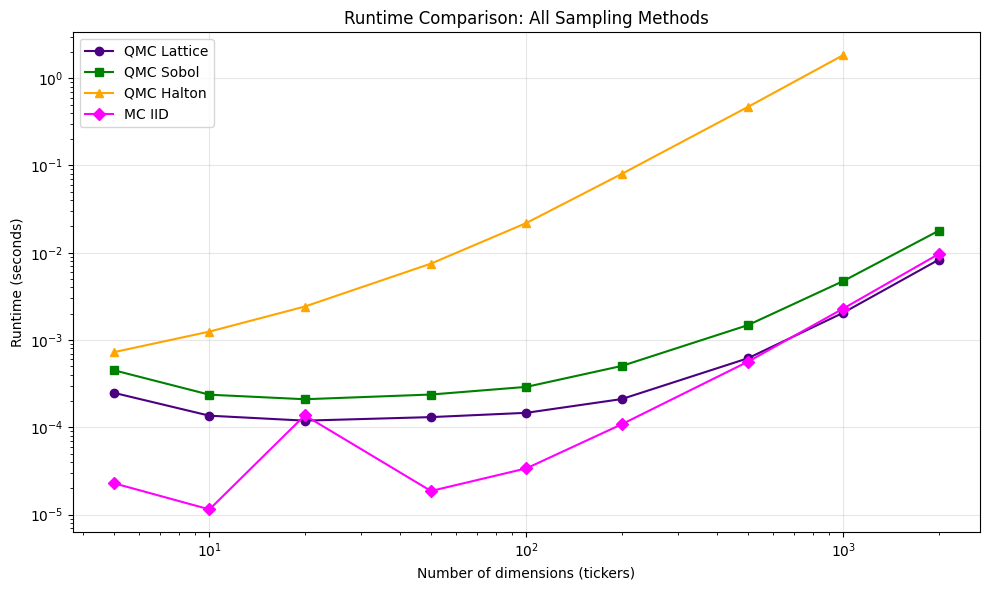

In [18]:
# Use powers of 2 for lattice (required by default order)
dimensions = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]

# Measure runtime for all sampling methods
sampler_types = ['lattice', 'sobol', 'halton', 'iid']
colors = ['indigo', 'green', 'orange', 'magenta']
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(10, 6))

for sampler, color, marker in zip(sampler_types, colors, markers):
    times = []
    for n in dimensions:
        num_samples = 2**int(np.log2(n) + 1)
        try:
            t = timeit.timeit(f'gen_weights("{sampler}", {n}, {num_samples})',
                      globals=globals(),
                      number=1)
        except Exception as e:
            print(f"Skipping sampler={sampler} dim={n}: {e}")
            t = float('nan')
        times.append(t)
    plt.loglog(dimensions, times, color=color, marker=marker, linestyle='-',
               label=f'QMC {sampler.capitalize()}' if sampler != 'iid' else 'MC IID',
               linewidth=1.5, markersize=6)

plt.title("Runtime Comparison: All Sampling Methods", fontsize=12)
plt.legend()
plt.xlabel("Number of dimensions (tickers)")
plt.ylabel("Runtime (seconds)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

## CPU time

### Lattice CPU

In [19]:

lattice_results_cpu = []

for tickers, portfolios in params:
    start_time = time.process_time()
    lattice_weights = gen_weights_lattice(tickers, portfolios)
    end_time = time.process_time()
    time_taken = end_time - start_time
    
    lattice_results_cpu.append({
        'Tickers': tickers,
        'Portfolios': portfolios,
        'Lattice Time (s)': time_taken
    })

df_cpu_time =  pd.DataFrame(lattice_results_cpu)

### IID CPU

In [20]:
iid_results_cpu = []

for tickers, portfolios in params:
    start_time = time.process_time()
    iid_weights = gen_weights_iid(tickers, portfolios)
    end_time = time.process_time()
    time_taken = end_time - start_time
    
    iid_results_cpu.append(time_taken)


df_cpu_time['IID Time (s)'] = iid_results_cpu

In [21]:
df_cpu_time

,Tickers,Portfolios,Lattice Time (s),IID Time (s)
0,4,16384,0.026960,0.022451
1,10,32768,0.001304,0.001418
2,20,65536,0.002624,0.003002
3,100,131072,0.023719,0.032233
4,500,262144,0.318058,0.318681
5,1000,524288,1.271259,1.380204


## Backtesting

*Backtesting* - a method used to retrospectively evaluate the effectiveness of a strategy by simulating its performance using historical data

In [22]:
aapl = df[df['Ticker']== 'AAPL'].reset_index()
amzn = df[df['Ticker']== 'AMZN'].reset_index()
csco = df[df['Ticker']== 'CSCO'].reset_index()
ibm = df[df['Ticker']== 'IBM'].reset_index()

In [23]:
aapl = aapl.set_index('Date')
amzn = amzn.set_index('Date')
csco = csco.set_index('Date')
ibm = ibm.set_index('Date')


In [24]:
# normalize return
for stock_df in (aapl,  amzn, csco, ibm):
    stock_df['Norm Return'] = stock_df['Adj Close Price'] / stock_df.iloc[0]['Adj Close Price']

In [25]:
principal = 10000 # starting investment value
num_ports = 2**14  # 16384 portfolios
risk_level = "high"

# Generate weights and compute Sharpe ratios for all samplers
w_lattice = gen_weights('lattice', 4, num_ports)
sr_lattice = sharpe(w_lattice, lr)

w_sobol = gen_weights('sobol', 4, num_ports)
sr_sobol = sharpe(w_sobol, lr)

w_halton = gen_weights('halton', 4, num_ports)
sr_halton = sharpe(w_halton, lr)

w_iid = gen_weights('iid', 4, num_ports)
sr_iid = sharpe(w_iid, lr)

### Portfolio performance for all sampling methods
We compute portfolio values using weights from all four sampling methods: Lattice, Sobol, Halton (QMC), and IID (MC).

In [26]:
# Compute portfolio values for all sampling methods
def compute_portfolio_value(stock_dfs, weights_dict, risk_level, principal):
    """Compute total portfolio value over time given weights."""
    positions = []
    for stock_df, alloc in zip(stock_dfs, weights_dict[risk_level]):
        pos = stock_df['Norm Return'] * alloc * principal
        positions.append(pos)
    total = pd.concat(positions, axis=1).sum(axis=1)
    return total

# Get stock dataframes
stocks = (aapl, amzn, csco, ibm)

# Compute portfolio values for each method
portf_lattice = compute_portfolio_value(stocks, sr_lattice, risk_level, principal)
portf_sobol = compute_portfolio_value(stocks, sr_sobol, risk_level, principal)
portf_halton = compute_portfolio_value(stocks, sr_halton, risk_level, principal)
portf_iid = compute_portfolio_value(stocks, sr_iid, risk_level, principal)

In [27]:
# Combine all portfolio values into a single DataFrame
all_portfolios = pd.DataFrame({
    'Lattice': portf_lattice,
    'Sobol': portf_sobol,
    'Halton': portf_halton,
    'IID': portf_iid
})
all_portfolios

,Lattice,Sobol,Halton,IID
Date,,,,
2014-01-02,10000.000000,10000.000000,10000.000000,10000.000000
2014-01-03,9914.454766,9954.747657,10019.569384,9959.884641
2014-01-06,9924.207531,9946.559384,9986.379960,9941.582541
2014-01-07,9985.891790,10046.586212,10148.986857,10047.361113
2014-01-08,10017.534079,10046.299798,10112.632095,10062.876568
...,...,...,...,...
2025-12-08,100942.529877,83574.094712,54698.595034,86109.820675
2025-12-09,101073.614048,83693.030408,54918.670570,86321.614878
2025-12-10,101971.322854,84462.834988,55556.271976,87274.969030


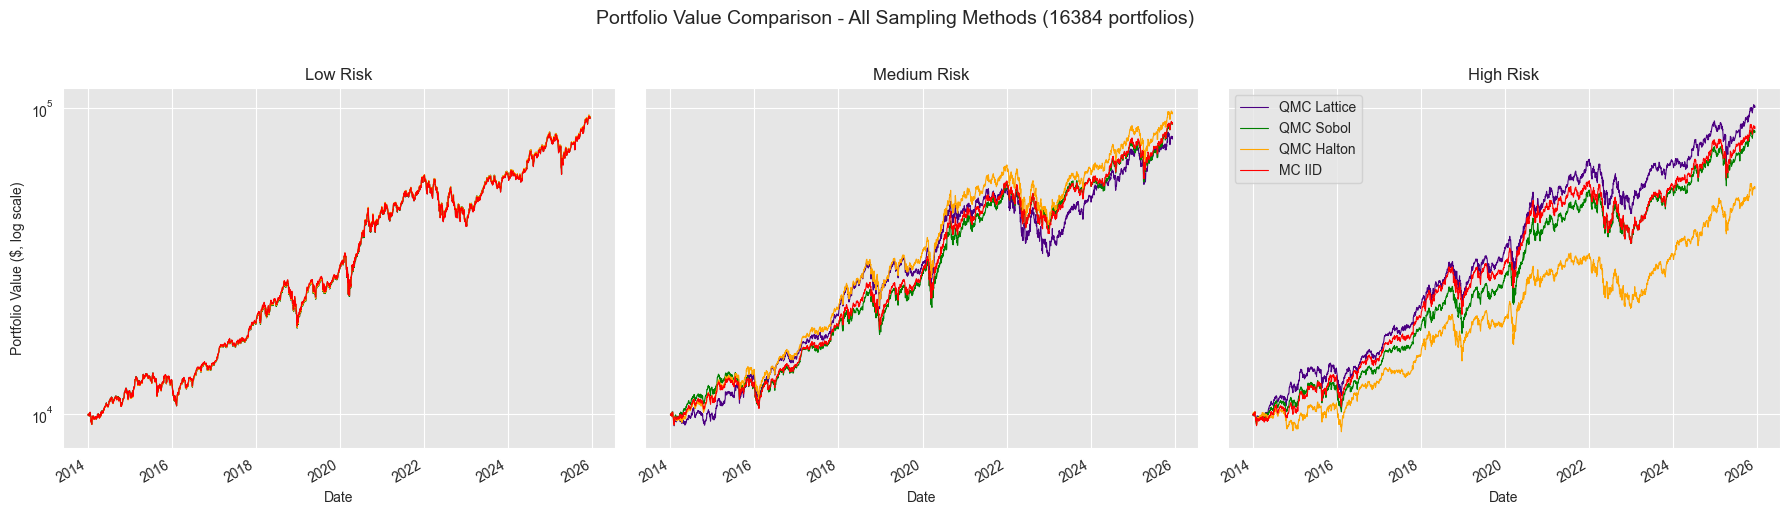

In [28]:
# Plot portfolio values for all sampling methods across all risk levels
sn.set_style("darkgrid", {"axes.facecolor": ".9"})
colors = ['indigo', 'green', 'orange', 'red']
risk_levels = ['low', 'medium', 'high']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    # Compute portfolio values for this risk level
    portf_data = pd.DataFrame({
        'Lattice': compute_portfolio_value(stocks, sr_lattice, risk, principal),
        'Sobol': compute_portfolio_value(stocks, sr_sobol, risk, principal),
        'Halton': compute_portfolio_value(stocks, sr_halton, risk, principal),
        'IID': compute_portfolio_value(stocks, sr_iid, risk, principal)
    })
    
    portf_data.plot(ax=axes[idx], logy=True, linewidth=0.8, color=colors, legend=(idx == 2))
    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')
    if idx == 0:
        axes[idx].set_ylabel('Portfolio Value ($, log scale)')

# Add common legend
axes[2].legend(['QMC Lattice', 'QMC Sobol', 'QMC Halton', 'MC IID'], loc='upper left')
fig.suptitle(f'Portfolio Value Comparison - All Sampling Methods ({num_ports} portfolios)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show();

In [29]:
cat = 'low'
print(f"{cat} risk weights:")
print(f"Lattice: {sr_lattice[cat]}")
print(f"Sobol:   {sr_sobol[cat]}")
print(f"Halton:  {sr_halton[cat]}")
print(f"IID:     {sr_iid[cat]}")

low risk weights:
Lattice: [0.349, 0.141, 0.262, 0.248]
Sobol:   [0.353, 0.136, 0.265, 0.246]
Halton:  [0.349, 0.146, 0.256, 0.249]
IID:     [0.341, 0.144, 0.281, 0.234]


In [30]:
# Compute differences relative to IID baseline
differences = pd.DataFrame({
    'Lattice vs IID': (all_portfolios['Lattice'] - all_portfolios['IID']) / principal,
    'Sobol vs IID': (all_portfolios['Sobol'] - all_portfolios['IID']) / principal,
    'Halton vs IID': (all_portfolios['Halton'] - all_portfolios['IID']) / principal
})

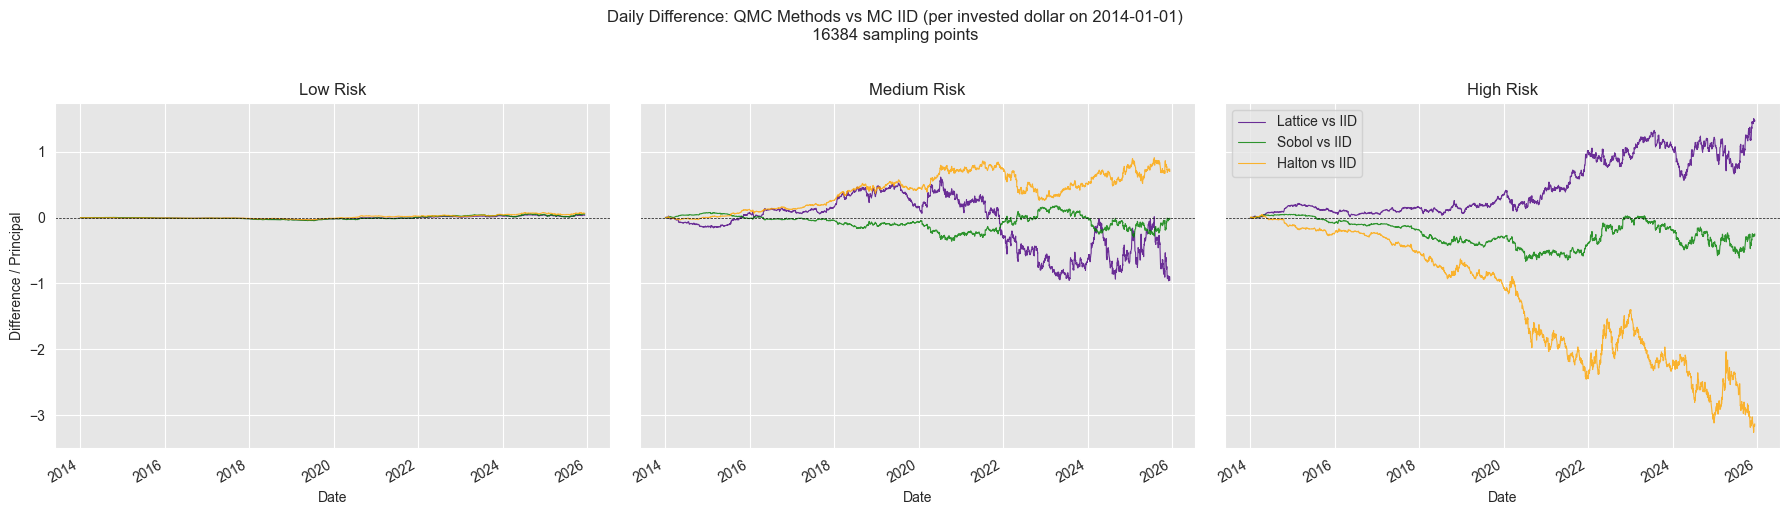

In [31]:
# Plot differences between QMC methods and MC IID for all risk levels
colors_diff = ['indigo', 'green', 'orange']
risk_levels = ['low', 'medium', 'high']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    # Compute portfolio values for this risk level
    portf_lattice_r = compute_portfolio_value(stocks, sr_lattice, risk, principal)
    portf_sobol_r = compute_portfolio_value(stocks, sr_sobol, risk, principal)
    portf_halton_r = compute_portfolio_value(stocks, sr_halton, risk, principal)
    portf_iid_r = compute_portfolio_value(stocks, sr_iid, risk, principal)
    
    # Compute differences
    diff_data = pd.DataFrame({
        'Lattice vs IID': (portf_lattice_r - portf_iid_r) / principal,
        'Sobol vs IID': (portf_sobol_r - portf_iid_r) / principal,
        'Halton vs IID': (portf_halton_r - portf_iid_r) / principal
    })
    
    diff_data.plot(ax=axes[idx], linewidth=0.8, color=colors_diff, alpha=0.8, legend=(idx == 2))
    axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')
    if idx == 0:
        axes[idx].set_ylabel('Difference / Principal')

# Add common legend
axes[2].legend(loc='upper left')
fig.suptitle(f'Daily Difference: QMC Methods vs MC IID (per invested dollar on {start_date})\n{num_ports} sampling points', fontsize=12, y=1.02)
plt.tight_layout()
plt.show();

# References

1. Choi, S.-C. T., Hickernell, F. J., McCourt, M., Rathinavel, J., & Sorokin, A. (2020). QMCPy: A quasi-Monte Carlo Python library. https://qmcpy.org/

2. Sharpe, W. F. (1966). Mutual fund performance. *Journal of Business*, 39(1), 119-138.

3.  Niederreiter, H. (1992). *Random Number Generation and Quasi-Monte Carlo Methods*. SIAM.

4. Sloan, I. H., & Joe, S. (1994). *Lattice Methods for Multiple Integration*. Oxford University Press.

5. Sobol', I. M. (1967). On the distribution of points in a cube and the approximate evaluation of integrals. *USSR Computational Mathematics and Mathematical Physics*, 7(4), 86-112.

6. Markowitz, H. (1952). Portfolio selection. *Journal of Finance*, 7(1), 77-91.